In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [5]:
# Defining the Input and output data

df = pd.read_excel("Input.xlsx")
df2 = pd.read_excel("Output.xlsx")

Data_input = df.values
Data_output = df2.values

combined_data = np.concatenate((Data_input, Data_output), axis=1)

# parameters
in_num = 3
n_num = 128
L_num = 6
o_num = 1

# Splitting the data into training and test sets
X = combined_data[:, :-1]  # Assuming the last column is the output
y = combined_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize MinMaxScaler to scale data 
scaler = MinMaxScaler().fit(X_train)
# Rescale the training and test data based on the training set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
# We used 5-fold cross-validation to compare different models and determine optimal hyperparameters from the training set.
# For example, in the case of the DNN, the number of layers and neurons were selected as hyperparameters and applied to 
# the final model.

In [7]:
# Defining the NN model

from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(in_num, n_num)  
        self.fc2 = nn.Linear(n_num, n_num)
        self.fc3 = nn.Linear(n_num, n_num)
        self.fc4 = nn.Linear(n_num, n_num)
        self.fc5 = nn.Linear(n_num, o_num)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [8]:
from torch.utils.data import TensorDataset, DataLoader

# Converting data to tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Data loaders
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

# Model, loss, and optimizer
model = DNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
epochs = 60


In [9]:
# calculating R^2

def r_squared(y_true, y_pred):
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return r2

# Initialize lists to monitor loss and R-squared per epoch
train_losses = []
test_losses = []
train_r2_scores = []
test_r2_scores = []

# Training the Predictor NN

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    all_y_true_train, all_y_pred_train = [], []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    # Collecting data for R-squared calculation
        all_y_true_train.append(y_batch.numpy())
        all_y_pred_train.append(outputs.detach().numpy().squeeze())
    
    # Calculate and store the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Calculate training R-squared
    all_y_true_train = np.concatenate(all_y_true_train)
    all_y_pred_train = np.concatenate(all_y_pred_train)
    train_r2 = r_squared(all_y_true_train, all_y_pred_train)
    train_r2_scores.append(train_r2)
    
    # Test phase
    model.eval()
    test_loss = 0.0
    all_y_true_test, all_y_pred_test = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            test_loss += loss.item()
            
            # Collecting data for R-squared calculation
            all_y_true_test.append(y_batch.numpy())
            all_y_pred_test.append(outputs.numpy().squeeze())
    
    # Calculate and store the average test loss
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    all_y_true_test = np.concatenate(all_y_true_test)
    all_y_pred_test = np.concatenate(all_y_pred_test)
    test_r2 = r_squared(all_y_true_test, all_y_pred_test)
    test_r2_scores.append(test_r2)
    
    # Print epoch results with higher precision
    print(f'Epoch {epoch+1}, '
          f'Train Loss: {train_loss:.8e}, '  # Using scientific notation for precision
          f'Test Loss: {test_loss:.8e}, '
          f'Train R^2: {train_r2:.8f}, '
          f'Test R^2: {test_r2:.8f}')



Epoch 1, Train Loss: 9.58994838e-03, Test Loss: 2.78885608e-04, Train R^2: -0.26981091, Test R^2: 0.96229634
Epoch 2, Train Loss: 1.59014418e-04, Test Loss: 1.21979650e-04, Train R^2: 0.97895842, Test R^2: 0.98350311
Epoch 3, Train Loss: 8.72084078e-05, Test Loss: 7.17208556e-05, Train R^2: 0.98845926, Test R^2: 0.99029953
Epoch 4, Train Loss: 5.65760648e-05, Test Loss: 4.93714641e-05, Train R^2: 0.99251205, Test R^2: 0.99332625
Epoch 5, Train Loss: 4.09483221e-05, Test Loss: 4.07940406e-05, Train R^2: 0.99458981, Test R^2: 0.99448291
Epoch 6, Train Loss: 3.27565817e-05, Test Loss: 4.49398827e-05, Train R^2: 0.99566915, Test R^2: 0.99392067
Epoch 7, Train Loss: 2.83908651e-05, Test Loss: 4.83052505e-05, Train R^2: 0.99624377, Test R^2: 0.99346814
Epoch 8, Train Loss: 2.87333072e-05, Test Loss: 2.77396979e-05, Train R^2: 0.99620522, Test R^2: 0.99625208
Epoch 9, Train Loss: 2.39463720e-05, Test Loss: 2.21122019e-05, Train R^2: 0.99683675, Test R^2: 0.99701048
Epoch 10, Train Loss: 2.488

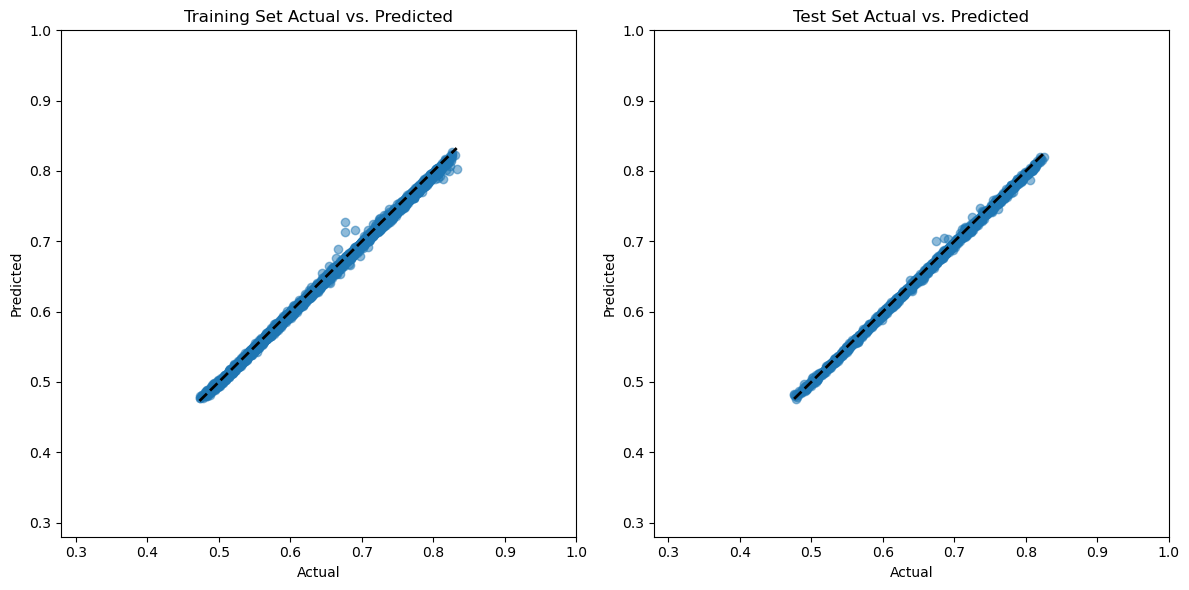

In [10]:
# Predictions for training set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_train_pred = model(torch.FloatTensor(X_train)).numpy().squeeze()
    y_test_pred = model(torch.FloatTensor(X_test)).numpy().squeeze()

# Plotting y_train predictions over y_train real
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Set Actual vs. Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlim(0.28, 1)  
plt.ylim(0.28, 1)  


# Plotting y_test predictions over y_test real
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlim(0.28, 1) 
plt.ylim(0.28, 1)  

plt.tight_layout()
plt.show()


In [12]:

import torch
from scipy.optimize import minimize
import numpy as np

# optimizing the compliance function in the Predictor NN

def objective_function(x):
    x_tensor = torch.FloatTensor(x.reshape(1, -1))
    with torch.no_grad():
        model.eval()
        y_pred = model(x_tensor).item()
    return -y_pred

# Try multiple initial guesses
num_runs = 100
results_matrix = np.zeros((num_runs, 4))
for i in range(num_runs):
    x0 = np.random.rand(3)  # Random start point in the range [0, 1]
    result = minimize(objective_function, x0, method='Nelder-Mead', bounds=[(0, 1)] * 3)
    results_matrix[i, :3] = result.x
    results_matrix[i, 3] = -result.fun

# Sorting results by output
sorted_results_matrix = results_matrix[results_matrix[:, 3].argsort()[::-1]]

best_inputs = sorted_results_matrix[0, :3]
best_output = sorted_results_matrix[0, 3]


df = pd.DataFrame(sorted_results_matrix)
excel_file = "sorted_results.xlsx"
df.to_excel(excel_file, index=False)


num: 100


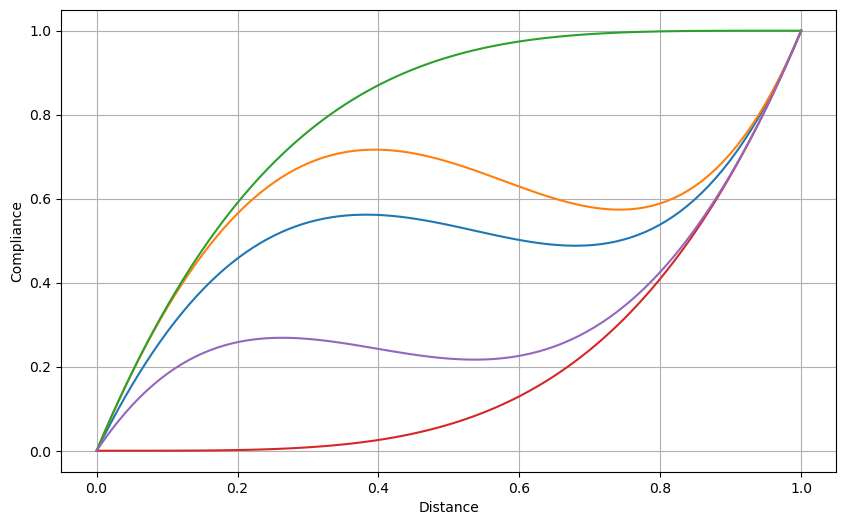

In [92]:
# ploting the Optimal compliance distribution 

import matplotlib.pyplot as plt
import torch

# Assuming sorted_results_matrix is already defined and has a shape of (100, >=5)
n_rows = sorted_results_matrix.shape[0]  # Number of rows to iterate over, assumed to be 100

print("num:", n_rows)


# Create a plot
plt.figure(figsize=(10, 6))

for i in range(n_rows):   
    Opt_x = sorted_results_matrix[i, :5]
    control_points = [(0, 0), (0.25, Opt_x[0]), (0.5, Opt_x[1]), (0.75, Opt_x[2]), (1, 1)]

    t = torch.linspace(0, 1, 100)  # More points for a smoother curve

    Bx = (1 - t)**4 * control_points[0][0] + \
            4 * (1 - t)**3 * t * control_points[1][0] + \
            6 * (1 - t)**2 * t**2 * control_points[2][0] + \
            4 * (1 - t) * t**3 * control_points[3][0] + \
            t**4 * control_points[4][0]

    By = (1 - t)**4 * control_points[0][1] + \
            4 * (1 - t)**3 * t * control_points[1][1] + \
            6 * (1 - t)**2 * t**2 * control_points[2][1] + \
            4 * (1 - t) * t**3 * control_points[3][1] + \
            t**4 * control_points[4][1]

    # Plot each Bezier curve
    plt.plot(Bx.numpy(), By.numpy(), label=f'Row {i+1}')

plt.xlabel('Distance')
plt.ylabel('Compliance')
plt.grid(True)
plt.show()
